# To do: 

**un-scale predictions**

**modify eval_model to plot all lines in one plot**

**figure out why the test predictions are in the future, not the test phase**

**The current notebook is inspired from:**

Local methods: 

https://unit8co.github.io/darts/examples/14-transfer-learning.html#Part-1:-Local-models-on-the-air-dataset 

Transformer model: 

https://unit8co.github.io/darts/examples/06-Transformer-examples.html

Hyperparameter tuning:

https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.transformer_model.html

**Install and import packages**

In [ ]:
%pip install --upgrade jupyter
%pip install pandas
%pip install cmake
%pip install lightgbm
%pip install darts
%pip install seaborn
%pip install optuna
%pip install matplotlib
%pip install joblib
%pip install seaborn
%pip install tqdm
%pip install torch
%pip install sklearn
%pip install scikit-learn
%pip install pandas_profiling

In [2]:
#Imports

# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
import heapq

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

#hmm needed? 
import torch
import torch.nn as nn
#from torch import nn
import torch.optim as optim
import shutil
import sklearn
from sklearn.preprocessing import MinMaxScaler
#from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import * #everything

#loss metrics
from darts.metrics import mape
from darts.metrics import smape
from darts.utils.losses import SmapeLoss

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#hyperparameter tuning
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

#extras
import os
import time
import random
from datetime import datetime
from itertools import product
from typing import List, Tuple, Dict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge


# Load and inspect data

**Define loading and preprocessing function**

In [3]:
def load_preprocess(csv_file):

    ''' Loading and preprocessing data from csv. Return list of time-series IDs and preprocessed csv.'''

    #Read data
    raw_data = pd.read_csv(csv_file)

    #Cut off before 1950
    raw_data = raw_data[raw_data['Year'] >= 1950]

    #Transform timestamp to datetime format
    raw_data['Year'] = pd.to_datetime(raw_data['Year'], format='%Y')

    #Drop "Code" column
    raw_data = raw_data.drop(['Code'], axis=1)

    #Rename columns
    raw_data = raw_data.rename(columns={"Life expectancy at birth (historical)":"LE", "Entity":"Country"})

    #Exclude entries that are not countries/territories
    exclude = ['Africa', 'Asia','Americas', 'Europe', 'High-income countries', 'More developed regions','Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World']

    # Subset the DataFrame based on the countries/territories of interest
    data_countries = raw_data.loc[~raw_data['Country'].isin(exclude)]

    #create list of countries for later
    countries = list(data_countries["Country"].unique())

    #Write to csv
    data_countries.to_csv('life_expectancy_data.csv', index=False)

    #Get dataframe for further work
    data_pd = pd.DataFrame(data_countries)

    return countries, data_pd

# Exploratory analysis

We leverage Pandas Profiling Report to get an idea of our data structure. It includes various statistics.

To check autocorrelation, we need to this for each time series individually. 


In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data_pd, tsmode=True, sortby="Year")
profile.to_file('profile_report.html')
profile

**Autocorrelation**

In [32]:
#Pivot DataFrame
data_wide = data_pd.pivot(index='Year', columns='Country', values='LE')

#Calculate autocorrelation
autocorr_results = data_wide.apply(lambda x: x.autocorr()) #series

#Extract the mean, sd and median
print(autocorr_results.mean())
print(autocorr_results.std())
print(autocorr_results.median())

0.9874793805916966
0.028249862885003686
0.9969719707409795


**Visualize a subset of countries**

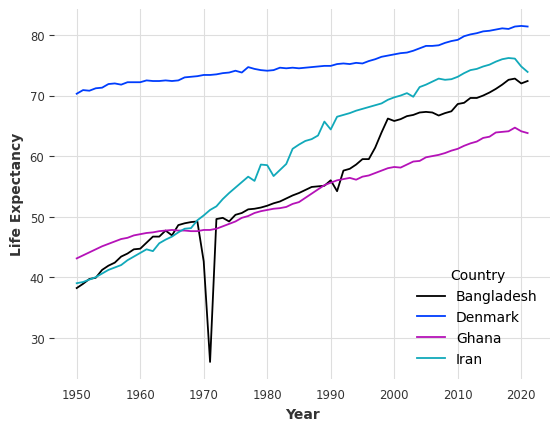

In [42]:
#Let's look at just a few countries
countries_of_interest = ['Denmark', 'Bangladesh', 'Iran','Ghana']
subset_df = data_pd.loc[data_pd['Country'].isin(countries_of_interest)]

#Plot
sns.lineplot(x="Year", y="LE",
             hue="Country",
             data=subset_df)

plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.legend(title="Country")
plt.show()

# Local methods

**Splits**

NB: These splits are chosen to accommodate comparison with the Transformer, where we need to split in validation as well. 
Therefore, the training split it slightly larger than the usual 80%.

Training: 62 years (1950-2011) = 86 %. 

Testing: 10 years (2012-2021) = 14 %. 

Forecasting horizon: 10 years. 



**Defining functions**

In [4]:
def transform_split(dataframe: pd.DataFrame) -> Tuple[List[TimeSeries], List[TimeSeries]]:
    ''' Transform DataFrame to TimeSeries object.
    Split in train and test. Return full TimeSeries object, train TimeSeries object, and test TimeSeries object. '''
    
    #To timeseries
    dataset_ts = TimeSeries.from_group_dataframe(df=dataframe, 
                                             group_cols=['Country'],
                                             time_col='Year', 
                                             value_cols='LE')
    # Split train/test
    print("splitting train/test...")
    train: List[TimeSeries] = [s[:-HORIZON] for s in dataset_ts]
    test: List[TimeSeries] = [s[-HORIZON:] for s in dataset_ts]

    print("There are in total {} series".format(len(train))),
    print("Years applied for training: {}".format(np.mean([len(s) for s in train])),
    print("Years applied for testing (forecasting horizon): {}".format(np.mean([len(s) for s in test]))
        )
    )
    return dataset_ts, train, test


def eval_forecasts(
    name,
    pred_series: List[TimeSeries], 
    test_or_val_series: List[TimeSeries],
) -> List[float]:
    ''' Computing sMAPEs between predictions and ground truth (test data). 
    Plotting the distribution and retrieving the median sMAPE. '''
    print("computing sMAPEs...")
    smapes = smape(test_or_val_series, pred_series)
    plt.figure()
    plt.hist(smapes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("Model: {}".format(name))
    subtitle = "Median sMAPE: {:.3f} and mean sMAPE: {:.2f} +- {:.2f}".format(np.median(smapes), np.mean(smapes), np.std(smapes))
    plt.text(0.5, 0.92, subtitle, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.show()
    plt.close()
    return smapes



def eval_local_model(
    ID_list: List[str],
    train_series: List[TimeSeries], 
    test_series: List[TimeSeries], 
    model_cls, 
    **kwargs
) -> Tuple[List[float], float, List[Tuple[str, float]]]:

    ''' Fitting the model of choice to training data. Retrieving predictions for a given forecasting horizon.
    Extracting computation time. Extracting sMAPEs per time-series and the time-series with highest sMAPEs. '''

    #define empty lists for predictions and processing time
    preds = []
    start_time = time.time()

    #Fit model and predict for each series individually
    print("fitting models...")
    for series in tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=HORIZON)
        preds.append(pred)
    elapsed_time = time.time() - start_time

    name = model.__class__.__name__

    #Apply eval_forecasts function to extract sMAPEs and plot
    print("extracting sMAPEs...")
    smapes = eval_forecasts(name, preds, test_series)

    #Extract sMAPES per time-series and time-series with highest sMAPEs
    smapes_pr_country = list(zip(countries, smapes))
    highest_smapes = heapq.nlargest(10, smapes_pr_country, key=lambda x: x[1])
    
    return smapes, elapsed_time, smapes_pr_country, highest_smapes

def plot_models(method_to_elapsed_times, method_to_smapes):

    ''' Plotting the median sMAPEs for various methods as well as computation time. '''
    
    shapes = ["o", "s", "*"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    styles = list(product(shapes, colors))

    plt.figure(figsize=(6, 6), dpi=100)
    for i, method in enumerate(method_to_elapsed_times.keys()):
        t = method_to_elapsed_times[method]
        s = styles[i]
        plt.semilogx(
            [t],
            [np.median(method_to_smapes[method])],
            s[0],
            color=s[1],
            label=method,
            markersize=13,
        )
    plt.xlabel("elapsed time [s]")
    plt.ylabel("median sMAPE over all series")
    plt.legend(bbox_to_anchor=(1.4, 1.0), frameon=True);

**Load, preprocess, split and transform data format**

In [5]:
HORIZON = 10

countries, data_pd = load_preprocess("life-expectancy.csv")

data, train, test = transform_split(data_pd)

splitting train/test...
There are in total 237 series
Years applied for testing (forecasting horizon): 10.0
Years applied for training: 62.0 None


**Naive Drift**

fitting models...


100%|██████████| 237/237 [00:00<00:00, 438.48it/s]


extracting sMAPEs...
computing sMAPEs...


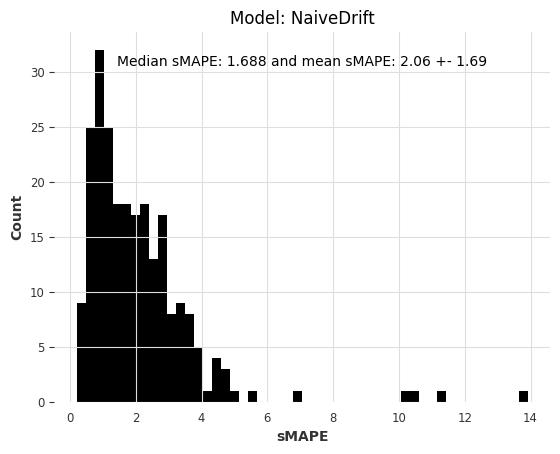

In [34]:
naive_smapes, naive_time, naive_smapes_pr_country, naive_highest_smapes = eval_local_model(countries, train, test, NaiveDrift)

In [44]:
naive_highest_smapes

[('Eswatini', 13.911730785413646),
 ('Syria', 11.192632210736859),
 ('Zimbabwe', 10.425183250420115),
 ('Lesotho', 10.086673287589845),
 ('Yemen', 6.9899656439462134),
 ('Somalia', 5.528986492563007),
 ('Oman', 5.031317420648938),
 ('Namibia', 4.840160791854798),
 ('Mexico', 4.7340682590118774),
 ('Mayotte', 4.69834367347323)]

**Theta**

fitting models...


100%|██████████| 237/237 [00:01<00:00, 161.49it/s]


extracting sMAPEs...
computing sMAPEs...


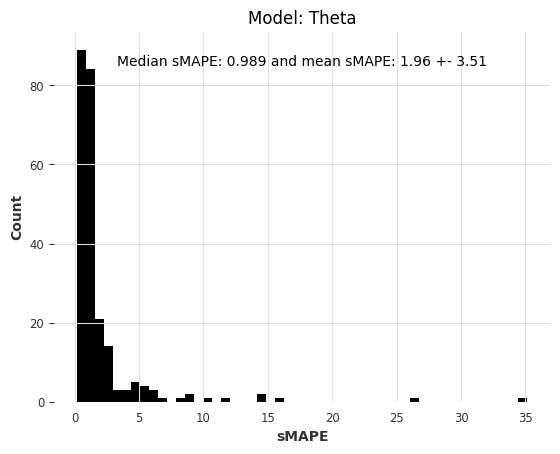

In [35]:
from darts.models import Theta

theta_smapes, theta_time, theta_smapes_pr_country, theta_highest_smapes = eval_local_model(countries, train, test, Theta, theta = 1.5)

#Theta = 1.5 corresponds to setting the drift rate for the Theta models generated
#A constant value for the gradient magnitude in the scalar field selection operation; 
#setting theta = 0 leads to only selecting positive gradients while increasing the value to larger constants 
#selects steeper regions of the landscape where both positive and negative gradients are present. 
#By default, theorist-darts sets theta = 2.5. 
#Using different values of theta allows exploration of alternative search spaces during the NAS process, 
#potentially leading to different optimal architectures depending on the problem domain. 
#Therefore, changing theta = 1.5 could alter the family of architectures searched, 
#leading to variations in final performance metrics across runs with differing random seeds and noise.

In [45]:
theta_highest_smapes

[('South Sudan', 35.16169049986351),
 ('Rwanda', 26.061874457619183),
 ('Sudan', 15.966892866940324),
 ('Eswatini', 14.603575947320834),
 ('Burundi', 14.383925678818388),
 ('Zimbabwe', 11.379583570967919),
 ('Lesotho', 10.441136349959878),
 ('Syria', 8.854783422734998),
 ('Somalia', 8.853118845558134),
 ('Haiti', 8.351557607115023)]

**ARIMA**

fitting models...


100%|██████████| 237/237 [00:12<00:00, 18.35it/s]


extracting sMAPEs...
computing sMAPEs...


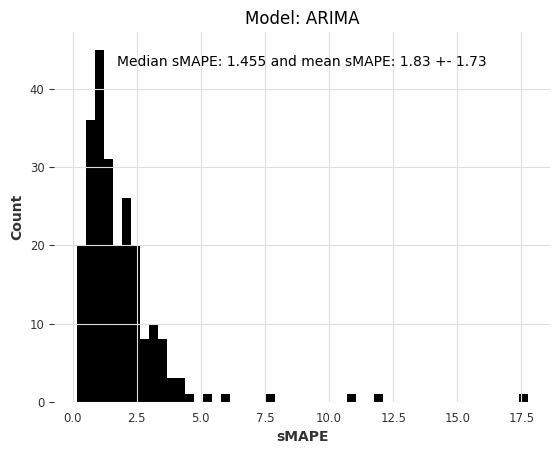

In [36]:
warnings.filterwarnings("ignore")  # ARIMA generates lots of warnings
arima_smapes, arima_time, arima_smapes_pr_country, arima_highest_smapes = eval_local_model(countries, train, test, ARIMA, p=1, d=1, q=1, trend = 't')

#p (int) – Order (number of time lags) of the autoregressive model (AR).
#d (int) – The order of differentiation; i.e., the number of times the data have had past values subtracted (I).
#q (int) – The size of the moving average window (MA).
#trend (str) – Parameter controlling the deterministic trend. ‘n’ indicates no trend, ‘c’ a constant term, ‘t’ linear trend in time, and ‘ct’ includes both.

In [46]:
arima_highest_smapes

[('Libya', 17.740942691179715),
 ('Syria', 11.771773970130033),
 ('Haiti', 10.972496025399051),
 ('South Africa', 7.6149186756226435),
 ('Yemen', 5.935603177943033),
 ('Guatemala', 5.242737485398845),
 ('North Korea', 4.703037339699344),
 ('Somalia', 4.357612567702702),
 ('Jamaica', 4.292707492873628),
 ('Ethiopia', 4.198051846214197)]

**Visual comparison**

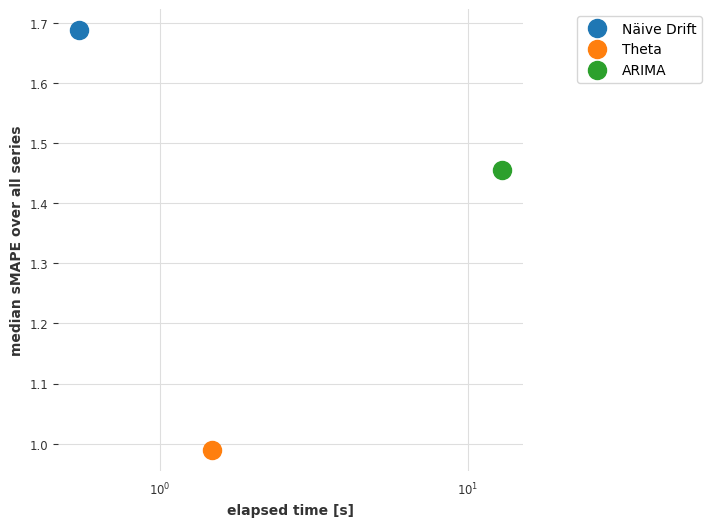

In [37]:
smapes = {
    "Näive Drift": naive_smapes,
    "Theta": theta_smapes,
    "ARIMA": arima_smapes,
}

elapsed_times = {
    "Näive Drift": naive_time,
    "Theta": theta_time,
    "ARIMA": arima_time,
}

plot_models(elapsed_times, smapes)

# Transformer

**Splits**

Training: 52 years (1950-2001) = 70%

Validation: 10 years (2002-2011) = 15%

Testing: 10 years (2012-2021) = 15%

Forecasting horizon: 10 years.

We load the data from DataFrame again to make new splits.

**Define functions**

In [ ]:
def transform_split_scale(dataframe: pd.DataFrame) -> Tuple[List[TimeSeries], List[TimeSeries],List[TimeSeries],List[TimeSeries]]:
    
    ''' Transform DataFrame to TimeSeries object. Scale data from 0-1.
    Split in train, vald, and test. Return full TimeSeries object, train TimeSeries object, and test TimeSeries object. '''

    #To timeseries
    dataset_ts = TimeSeries.from_group_dataframe(df=data_pd, 
                                             group_cols=['Country'],
                                             time_col='Year', 
                                             value_cols='LE')

    #Scale
    scaler_f = Scaler(scaler=MaxAbsScaler())
    data_scaled = scaler_f.fit_transform(dataset_ts)

    # Split train/val/test
    print("splitting train/val/test...")
    train: List[TimeSeries] = [s[:-2*HORIZON] for s in data_scaled]
    val: List[TimeSeries] = [s[-2*HORIZON:-HORIZON] for s in data_scaled]
    test: List[TimeSeries] = [s[-HORIZON:] for s in data_scaled]

    print("There are in total {} series".format(len(train))),
    print("Years applied for training: {}".format(np.mean([len(s) for s in train])),
    print("Years applied for validation (forecasting horizon): {}".format(np.mean([len(s) for s in val])),
    print("Years applied for testing (forecasting horizon): {}".format(np.mean([len(s) for s in test]))
        )
    )
    )
    return data_scaled, train, val, test

#def eval_model(preds, name, true_data, val_or_test_set):
#    ''' Extract sMAPEs for predictions on test set. Plot actual versus prediction.'''
#    
#    smapes = smape(preds, test_set)
#    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))
#    
#    #select some arbitrary time-series to plot
#    for i in [10, 50, 100, 150]:
#        plt.figure(figsize=(15, 5))
#        true_data[i].plot()
#        val_or_test_set[i].plot(label="actual")
#        preds[i].plot(label="forecast")

def eval_model(preds, name, true_data, val_or_test_set):
    ''' Extract sMAPEs for predictions on test set. Plot actual versus prediction.'''
    
    smapes = smape(preds, val_or_test_set)
    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))

    #Extract sMAPES per time-series and time-series with highest sMAPEs
    smapes_pr_country = list(zip(countries, smapes))
    highest_smapes = heapq.nlargest(10, smapes_pr_country, key=lambda x: x[1])
    
    plt.figure(figsize=(15, 5))
    #true_data[10].plot(label="True Data")  # Plot an arbitrary time-series (change index as needed)
    
    for i in [10, 50, 100, 150]:
        true_data[i].plot()
        val_or_test_set[i].plot(label="Actual")  # Plot actual data
        preds[i].plot(label="Forecast")  # Plot forecast data

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Actual vs. Forecast")
    plt.legend()
    plt.show()

    return smapes_pr_country, highest_smapes


**Preprocess data**

In [39]:
#Define horizon
HORIZON = 10

#Load
data_scaled, train_scaled, val_scaled, test_scaled = transform_split_scale(data_pd)

splitting train/val/test...
There are in total 237 series
Years applied for testing (forecasting horizon): 10.0
Years applied for validation (forecasting horizon): 10.0 None
Years applied for training: 52.0 None


In [5]:
##CURRENTLY NOT USED

def eval_forecasts(
    name,
    pred_series: List[TimeSeries], 
    test_or_val_series: List[TimeSeries],
) -> List[float]:

    print("computing sMAPEs...")
    smapes = smape(test_or_val_series, pred_series)
    plt.figure()
    plt.hist(smapes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    #plt.title("Median sMAPE: %.3f" % np.median(smapes).format(name))
    plt.title("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))
    plt.show()
    plt.close()
    return smapes

## CURRENTLY NOT USED ##

def eval_model(preds, name, train_set=train_scaled, val_set=val_scaled):
    smapes = smape(preds, val_set)
    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))

    for i in [10, 50, 100, 150, 250, 350]:
        plt.figure(figsize=(15, 5))
        train_set[i][-7 * DAY_DURATION :].plot()
        val_set[i].plot(label="actual")
        preds[i].plot(label="forecast")

def eval_global_model(
    country_list: List[str],
    train_series: List[TimeSeries], 
    test_series: List[TimeSeries], 
    model_cls, 
    **kwargs
) -> Tuple[List[float], float]:

    start_time = time.time()

    model = model_cls(**kwargs)
    print("fitting model...")
    model.fit(train_series)
    print("predicting...")
    preds = model.predict(n=HORIZON, series=train_series)

    elapsed_time = time.time() - start_time

    print("computing sMAPES...")
    smapes = eval_forecasts(preds, test_series)
    smapes_pr_country = list(zip(countries, smapes))
    highest_smapes = heapq.nlargest(10, smapes_pr_country, key=lambda x: x[1])

    return smapes, elapsed_time, smapes_pr_country, highest_smapes

In [ ]:
## CURRENTLY NOT USED
#transformer_smapes, transformer_elapsed_time, transformer_smapes_pr_country, transformer_highest_smapes = eval_global_model(countries, train, test, TransformerModel, input_chunk_length = 9, output_chunk_length = 1)

**Define and train transformer** 

In [40]:
def build_fit_model(
    IN_LEN,
    OUT_LEN,
    D_MODEL,
    N_HEAD,
    likelihood=None,
    callbacks=None,
    data = List[TimeSeries],
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters
    BATCH_SIZE = 16 #Number of time series (input and output sequences) used in each training pass. Default: 32.
    MAX_N_EPOCHS = 30 #Max number of epoch if early stopping not applied
    NR_EPOCHS_VAL_PERIOD = 1 #Number of epochs to wait before evaluating the validation loss
    #MAX_SAMPLES_PER_TS = 72 skipped as series are short
    ENCODER_LAYERS = 2 #few bc univariate and no seasonality - default 3
    DECODER_LAYERS = 2 #few bc univariate and no seasonality - default 3
    DIM_FEEDFORWARD = 128 #The dimension of the feedforward network model (default=512).

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.05, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    model = TransformerModel(
        input_chunk_length=IN_LEN,
        output_chunk_length=OUT_LEN,
        batch_size=BATCH_SIZE,
        n_epochs=MAX_N_EPOCHS,
        model_name="transformer_model",
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        d_model=D_MODEL,
        nhead=N_HEAD,
        num_encoder_layers=ENCODER_LAYERS,
        num_decoder_layers=DECODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=0.1,
        activation="relu",
        random_state=42,
        #optimizer_kwargs={"lr": lr}
        save_checkpoints=True, #save the best model and discard the rest (I think)
        force_reset=True,
    )

    # when validating during training, we can use a slightly longer validation set 
    # which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * HORIZON) + IN_LEN) : -HORIZON] for s in data_scaled]

    # train the model
    print("fitting model...")
    model.fit(
        series=train_scaled,
        val_series=model_val_set,
        #max_samples_per_ts=MAX_SAMPLES_PER_TS,
    )

    # reload best model over course of training
    print("loading best model...")
    best_model = model.load_from_checkpoint("transformer_model")

    return best_model

**Fit model**

In [ ]:
model = build_fit_model(
    IN_LEN = 10,
    OUT_LEN = 10,
    D_MODEL = 32, #low value since it is hard to learn a high-dimensional representation from an univariate time series
    N_HEAD = 16, #increase from default = 8. we compute multi-head attention with 16 heads of size d_model/nhead=32/16=2 each = low-dimensional heads that are hopefully suitable to learn from univariate time series
    data = data_scaled,
    )

**Forecast on validation horizon**

Predicting: 0it [00:00, ?it/s]

computing sMAPEs...


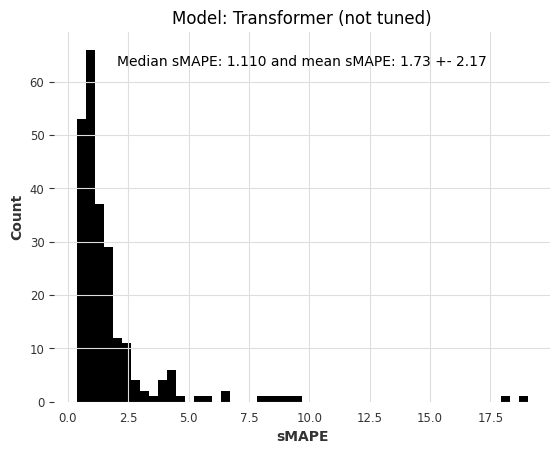

[1.7851256334618808,
 0.9335522996833762,
 0.6558983691462213,
 1.9268954853627112,
 1.6689552413130377,
 6.595267515593601,
 1.7310282326734272,
 0.481527796964266,
 0.8695703164614571,
 0.5330296885237893,
 0.6537634122557945,
 0.3776008458242432,
 0.9983733433698053,
 1.0008442573743912,
 1.342822962869063,
 0.9572800942812556,
 1.8176884497568047,
 0.46614756340792546,
 1.1194856780762061,
 0.7056790176009704,
 1.3256902664015298,
 0.8025517915670775,
 1.3263724900998008,
 1.6245025112558593,
 1.0963876933811256,
 0.6365971015233447,
 1.9518552642719642,
 4.373103418131598,
 0.9032454553426064,
 1.4769599534218507,
 2.430935527062094,
 0.8383452265721171,
 2.3027070756017034,
 3.517302007125759,
 4.409831598051032,
 0.9202946899722958,
 0.7561576532394328,
 1.1432175117539138,
 1.8410274884081979,
 2.0997824077343017,
 1.3737437585151373,
 0.7687204836536274,
 0.6656953795754689,
 0.9996861180964175,
 1.1956687112023463,
 4.137459222739158,
 1.1400782643211897,
 1.7254325735090024,

In [83]:
preds_transformer = model.predict(series=train_scaled, n=HORIZON)
eval_forecasts("Transformer (not tuned)", preds_transformer, val_scaled)

# Hyperparameter optimization

**Define function for optimization**

In [22]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, 4 and 10 years
    in_len = trial.suggest_int("years_in", 4, 10)

    # set out_len, between 1 and 9 years (it has to be strictly shorter than in_len).
    out_len = trial.suggest_int("years_out", 1, 9)

    # Other hyperparameters
    d_model = trial.suggest_int("D_MODEL", 16, 128)
    n_head = trial.suggest_int("N_HEAD", 2, 8)

    # build and train the model with these hyper-parameters:
    model = build_fit_model(
        IN_LEN =in_len,
        OUT_LEN =out_len,
        D_MODEL = d_model,
        N_HEAD = n_head,
        data = data_scaled,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=train_scaled, n=HORIZON)
    smapes = smape(val_scaled, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

**Optimize**

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")

study.optimize(objective, timeout=7200, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
#study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

# Transformer, tuned

Best value: 1.302255380588254

Best params: {'years_in': 9, 'years_out': 3, 'D_MODEL': 120, 'N_HEAD': 3}

In [ ]:
best_model = build_fit_model(
    IN_LEN = 9,
    OUT_LEN = 3,
    D_MODEL = 120, 
    N_HEAD = 3,
    data = data_scaled,
    )

Predicting: 0it [00:00, ?it/s]

computing sMAPEs...


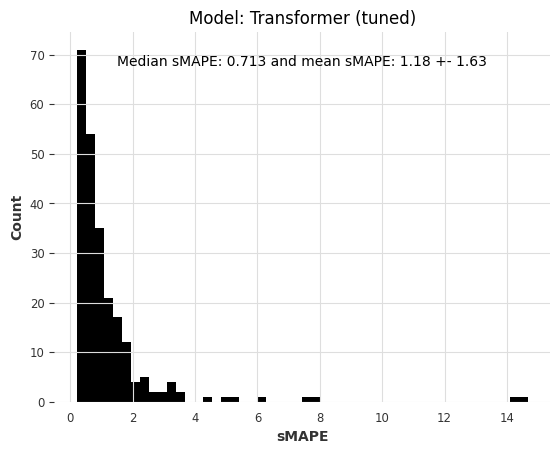

[0.8753624329811135,
 0.43436462367233764,
 0.7314796267026134,
 1.2771705089855838,
 1.1626823417866456,
 3.279186099753227,
 0.9473939693407867,
 0.366729532562175,
 0.4107651450778585,
 0.7002065256937781,
 0.5702611173905747,
 0.5208912350403521,
 0.44772344365823935,
 0.39356067656250127,
 0.6024974827443791,
 0.5270616745027022,
 1.883824946746112,
 0.2900691800361475,
 1.5468538413789747,
 0.30226550491339965,
 0.7612672440482251,
 1.1908302922366505,
 1.437284942099207,
 0.42821002538081937,
 0.3471268709495526,
 0.4057022638161232,
 1.2656622173361272,
 2.4351649030921876,
 0.33830099003398506,
 0.8895249386635529,
 1.5829370796649311,
 0.4176558019562313,
 0.9413051909327116,
 2.4564314042024655,
 2.519637733831238,
 1.7377467456650537,
 0.3939975420329477,
 0.512416874339639,
 1.2078145935388305,
 2.495407691146794,
 2.2181502638235533,
 0.31300491517792506,
 0.43496637857710596,
 0.3565293266032614,
 1.7911761494349434,
 2.330472254143852,
 0.5301855224447544,
 1.0172534417

In [43]:
best_preds_transformer = best_model.predict(series=train_scaled, n=HORIZON)
eval_forecasts("Transformer (tuned)", best_preds_transformer, val_scaled)

**TO DO: Un-scale predictions**

**Plot performance on a few selected time-series**

best model sMAPE: 1.18 +- 1.63


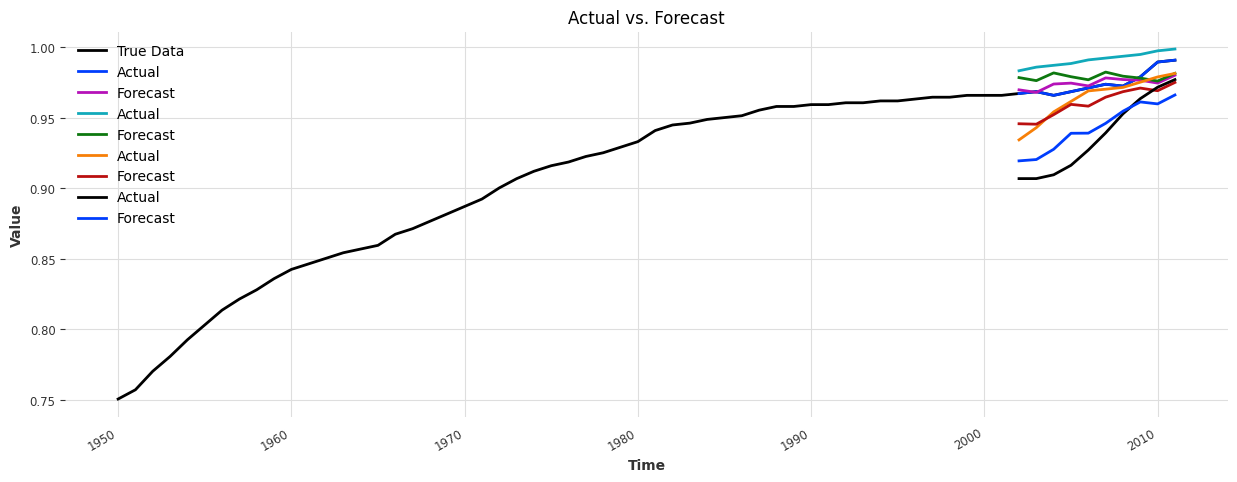

In [90]:
train_val_set = [s[:-HORIZON] for s in data_scaled]

eval_model(
    best_preds_transformer,
    "best model",
    true_data=train_val_set,
    val_or_test_set=val_scaled,
)

In [30]:
best_preds_transformer_test = best_model.predict(series=test_scaled, n=HORIZON)

Predicting: 0it [00:00, ?it/s]

In [53]:
train_val_set = [s[:-HORIZON] for s in data_scaled]

eval_model(
    best_preds_transformer_test,
    "best model, on test set",
    train_val_set=data_scaled,
    test_set=test_scaled,
)

TypeError: eval_model() got an unexpected keyword argument 'train_val_set'